# CASE 7: noise stats:  comparing ALMA and ADMIT 

Since we have noise estimates for both line and continuum from the ALMA query, we can cross-check that wiht the value ADMIT obtained.

In [1]:
from astroquery.admit import ADMIT
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth',25)


a = ADMIT()
a.check()

Found  /home/teuben/ALMA/study7/query/admit.db
Checking db.... 0
71 71 71
Database version: 27-feb-2022. core.py version: 26-feb-2022
header    : 1 entries
alma      : 115 entries
win       : 115 entries
lines     : 33 entries
sources   : 765 entries


## Line

Let's pick one selected MOUS first, the 7m data for NGC3504.  This is where one of the spw's has no signal, the CO and CS line are in two other spw's,and the fourth spw has fewer channels.





In [2]:
p1 = a.query(nchan='>2',obs_id='uid://A001/X87a/X70a')

select * from alma inner join win on (win.a_id = alma.id)  WHERE win.nchan>=2.0 AND alma.obs_id='uid://A001/X87a/X70a' 



In [3]:
# indeed there are 4 spw's
# p1
print(p1)

   id                obs_id target_name        s_ra      s_dec   frequency  \
0  51  uid://A001/X87a/X70a     NGC3504  165.796629  27.973328  229.366824   
1  52  uid://A001/X87a/X70a     NGC3504  165.796629  27.973328  230.733216   
2  53  uid://A001/X87a/X70a     NGC3504  165.796629  27.973328  243.689992   
3  54  uid://A001/X87a/X70a     NGC3504  165.796629  27.973328  245.564814   

         t_min  cont_sensitivity_bandwidth  sensitivity_10kms  \
0  57704.45099                  0.213557             6.807179   
1  57704.45099                  0.213557             6.514320   
2  57704.45099                  0.213557             6.754302   
3  57704.45099                  0.213557             7.155698   

           project_abstract                 obs_title  \
0  We propose to establi...  Pattern Speed in the ...   
1  We propose to establi...  Pattern Speed in the ...   
2  We propose to establi...  Pattern Speed in the ...   
3  We propose to establi...  Pattern Speed in the ...  

### Notes

1. alma says cont has rms  0.214 mJy/beam, but this is really over 4 spw's, each 1.9 GHz

2. alma says line10 should have 6.8 mJy.km/s;  channels are 4.8 km/s

3. ADMIT measured RMS in the spw's (rms_w) each at about 5 mJy/beam in a 4.8 km/s channel

## Continuum

In [4]:
p2 = a.query(nchan=1,obs_id='uid://A001/X87a/X70a')

select * from alma inner join win on (win.a_id = alma.id)  WHERE win.nchan=1 AND alma.obs_id='uid://A001/X87a/X70a' 



In [5]:
# there are 4, but there should be 5, the aggregative spw_19_21-23_25 is missing?
# p2
print(p2)

    id                obs_id target_name        s_ra      s_dec   frequency  \
0  108  uid://A001/X87a/X70a     NGC3504  165.796629  27.973328  229.366824   
1  109  uid://A001/X87a/X70a     NGC3504  165.796629  27.973328  230.733216   
2  110  uid://A001/X87a/X70a     NGC3504  165.796629  27.973328  243.689992   
3  111  uid://A001/X87a/X70a     NGC3504  165.796629  27.973328  245.564814   

         t_min  cont_sensitivity_bandwidth  sensitivity_10kms  \
0  57704.45099                  0.213557             6.807179   
1  57704.45099                  0.213557             6.514320   
2  57704.45099                  0.213557             6.754302   
3  57704.45099                  0.213557             7.155698   

           project_abstract                 obs_title  \
0  We propose to establi...  Pattern Speed in the ...   
1  We propose to establi...  Pattern Speed in the ...   
2  We propose to establi...  Pattern Speed in the ...   
3  We propose to establi...  Pattern Speed in the 

In [6]:
#  rough guess of what the aggregate cont rms would be from the 4 spw's
p2['rms_w'].mean()/2

0.0001840875

### Notes

1. alma claims cont sens is 0.213 mJy (but over 4 spw's)

2. admit measures about 0.37 per spw, which would imply about 0.18 for the aggregrate. A bit lower than what alma claimed.

3. Note that for this continuum record, the line sensitivity is still reported because they share the same MOUS.

## All data?

The obvious thing to try is do this for all data, and get a ratio of what ADMIT measured and what ALMA claims. This would be a good check on any remaining problems in the ADMIT results

to be continued...

In [7]:
p2c = a.query(nchan=1)
p2l = a.query(nchan='>2')

select * from alma inner join win on (win.a_id = alma.id)  WHERE win.nchan=1 

select * from alma inner join win on (win.a_id = alma.id)  WHERE win.nchan>=2.0 



In [8]:
ci=['cont_sensitivity_bandwidth','rms_w','nchan']
p2c[ci].tail()

,cont_sensitivity_bandwidth,rms_w,nchan
56,0.213557,0.000356,1
57,0.368794,0.000708,1
58,0.368794,0.000805,1
59,0.368794,0.000701,1
60,0.368794,0.000990,1


In [9]:
p2l[ci].tail()

,cont_sensitivity_bandwidth,rms_w,nchan
49,0.062059,0.002596,478
50,0.213557,0.005382,478
51,0.213557,0.004655,478
52,0.213557,0.005212,478
53,0.213557,0.001668,118


In [10]:
ratio_c = 1000*p2c['rms_w']/p2c['cont_sensitivity_bandwidth']/np.sqrt(p2c['nchan'])
ratio_l = 1000*p2l['rms_w']/p2l['cont_sensitivity_bandwidth']/np.sqrt(p2l['nchan'])

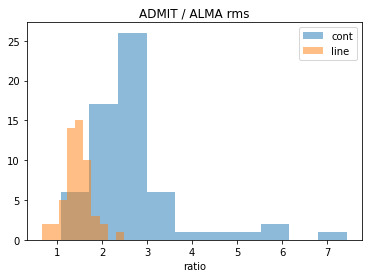

In [11]:
plt.hist(ratio_c,label="cont",alpha=0.5)
plt.hist(ratio_l,label="line",alpha=0.5)
plt.xlabel("ratio")
plt.title("ADMIT / ALMA rms")
plt.legend();

The ratio should be 2, if a MOUS has 4 spw's. For this we need the number of identical obs_id's. It certainly seems that the cubes measure a lower rms than expected from the ALMA records. This is probably the hanning smoothing, since we used $\sqrt{N_{chan}}$